# Lecture : Recommendation on Graphs

## Lab 01 : PageRank -- Solution

### Xavier Bresson, Nian Liu    


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/05_Recommendation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import sys; sys.path.insert(0, 'lib/')
import scipy.sparse.linalg
import warnings; warnings.filterwarnings("ignore")


# Synthetic small graph

In [3]:
# Data matrix 
mat = scipy.io.loadmat('datasets/pagerank_synthetic.mat')
W = mat['W']
W = scipy.sparse.csr_matrix(W)
Wref = W
X = mat['X'] #(x,y) coordinates (11,2)
n = X.shape[0]
d = X.shape[1]
E = mat['E']
XE = mat['X2']
print('num_nodes:',n)


num_nodes: 11


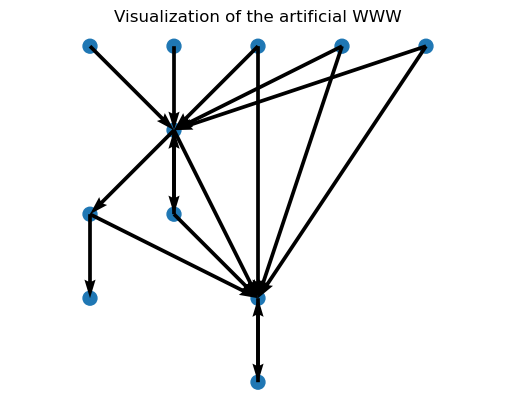

In [4]:
plt.figure(1)
size_vertex_plot = 100
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n))
plt.quiver(XE[:,0], XE[:,1], E[:,0], E[:,1], scale=1., units='xy') 
plt.title('Visualization of the artificial WWW')
plt.axis('equal')
plt.axis('off') 
plt.show()

### Question 1: Implementing PageRank using the Spectral Approach

Refer to Slide 17 from Lecture 5.

### Step 1: Construct the Degree Matrix D and its Inverse D$^{-1}$ from the Adjacency Matrix W

Account for cases where a node has zero degree.

Hint: You may find the following functions helpful: `numpy.sum()`, `numpy.where()`, and `numpy.diag()`.


In [ ]:
# Solve eigenproblem

# vectors of 1's
e = np.ones([n,1])/n 
one = np.ones([n,1])

############################################################################
# Your code starts
# Construct degree matrix D and its inverse invD with W (which is of dimension 11,11)
############################################################################
D = np.array(W.sum(axis=1),dtype='float32').squeeze() #without squeeze it was (11,1) with squeeze it becomes (11,) -> taking the sum along all neighbours j for a node row i
a_idx = np.zeros([n],dtype='int32')
a_idx[np.where(D<1./2)] = 1 #D now has the degree(out/in) for each node , so the places where there are no nodes (<0.5) we will still put 1 to make it irreducible maybe?
a = (1.0* a_idx)[:,None] # a now is of shape (11,1) and has 1 only in the place where there is no edge
invD = 1./(D+1e-10) #because D is not a matrix , no sense to take matrix inverse perhaps, just do normal inverse -> shape (11,)
invD[a_idx==1] = 0 # in that place where there were no edges/neighbours we will set it to 0 even its inverse also
invD = np.diag(invD)
############################################################################
# Your code ends
############################################################################


### Step 2: Transform the Adjacency Matrix W to a Stochastic and Irreducible Matrix

Refer to Slide 15 from Lecture 5.

Hint: You may find the following functions useful: `scipy.sparse.csr_matrix.todense()`, `numpy.dot()`, and `.T`.
    

In [ ]:
############################################################################
# Your code starts
# Assume a balance coefficient alpha=0.85
############################################################################
W = Wref.todense()
P = invD.dot(W).T
alpha = 0.85
P_hat = alpha* P +  alpha* e.dot(a.T) + (1.0-alpha)* e.dot(one.T) #TODO.note e -> 1/n and the a is used again to indicate the places where there is no edge, because in invD we had made that disconnected node as 0 so we still need to incorporate it somehow
############################################################################
# Your code ends
############################################################################


### Step 3: Perform Eigenvalue Decomposition (EVD) on the stochastic and irreducible matrix $\hat{P}$ to obtain the PageRank solution

Hint: Consider using `scipy.sparse.csr_matrix()` to convert the NumPy matrix to a sparse matrix, and `scipy.sparse.linalg.eigs()` to compute the eigenvalues and eigenvectors.


In [ ]:
############################################################################
# Your code starts
############################################################################
start = time.time()
P_hat = scipy.sparse.csr_matrix(P_hat)
lamb, U = scipy.sparse.linalg.eigs(P_hat, k=1, which='LM') 
x_pagerank = np.abs(U[:,0])/ np.sum(np.abs(U[:,0])) #TODO.node, abs here because U is complex so we are taking only the real part and then normalizing it
############################################################################
# Your code ends
############################################################################

# Computational time
print('Computational time for PageRank solution with EIGEN Method (sec):',time.time() - start)


In [ ]:
plt.figure(2)
size_vertex_plot = 1e3*6
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*x_pagerank) #TODO.node each node is scaled by the page rank value
plt.quiver(XE[:,0], XE[:,1], E[:,0], E[:,1], scale=1., units='xy') #TODO.note XE is edges
plt.title('PageRank solution with EIGEN Method.')
plt.axis('equal')
plt.axis('off') 
plt.show()

In [ ]:
# PageRank values
x = x_pagerank
val = np.sort(x)[::-1] 
idx = np.argsort(x)[::-1]
index = np.array(range(1,1+n))
in_degree = np.array(W.sum(axis=0)).squeeze(axis=0)
out_degree =  np.array(W.sum(axis=1)).squeeze(axis=1)
index = index[idx]
in_degree = in_degree[idx]
out_degree = out_degree[idx]
print('\n  ''Node'' | ''PageRank'' | ''In-degree'' | ''Out-degree'' ')
for i in range(n):
    print('   ',index[i], '  ', round(val[i],3) ,'      ', in_degree[i],'      ', out_degree[i], end='\n')

### Question 2: Implementing PageRank Using the Power Method

Refer to Slide 19 from Lecture 5.


In [ ]:
# Power Method

# Initialization
x = e
diffx = 1e10
k = 0

# Iterative scheme
start = time.time()
alpha = 0.85
while (k<1000) & (diffx>1e-6):
    
    # Update iteration
    k += 1

    # Update x
    xold = x
    
    ############################################################################
    # Your code starts
    ############################################################################
    x = alpha* P.dot(x) + e.dot( alpha* a.T.dot(x) + (1.0-alpha) )
    ############################################################################
    # Your code ends
    ############################################################################
    
    # Stopping condition
    diffx = np.linalg.norm(x-xold,1)
    
x_pagerank_PM = np.array(x).squeeze(axis=1)

# Computational time
print('Computational time for PageRank solution with POWER Method (sec):',time.time() - start)

plt.figure(3)
size_vertex_plot = 1e3*6
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*x_pagerank)
plt.quiver(XE[:,0], XE[:,1], E[:,0], E[:,1], scale=1., units='xy') 
plt.title('PageRank solution with POWER Method.')
plt.axis('equal')
plt.axis('off') 
plt.show()

# Real-world dataset CALIFORNIA

In [ ]:
###########################
# California graph
#   http://vlado.fmf.uni-lj.si/pub/networks/data/mix/mixed.htm
#   This graph was constructed by expanding a 200-page response set 
#   to a search engine query 'California'.
###########################

network = np.loadtxt('datasets/california.dat')
row = network[:,0]-1
col = network[:,1]-1
n = int(np.max(network))+1 # nb of vertices
ne = len(row)
print('nb of nodes=',n)
print('nb of edges=',ne)

# Create Adjacency matrix W
data = np.ones([ne])
W = scipy.sparse.csr_matrix((data, (row, col)), shape=(n, n))
Wref = W
print(W.shape)

# Plot adjacency matrix
plt.figure(4)
plt.spy(W,precision=0.01, markersize=1)
plt.show()

In [ ]:
# Solve eigenproblem

# vector of 1's
e = np.ones([n,1])/n 
one = np.ones([n,1])

# Dumpling vector
D = np.array(W.sum(axis=1),dtype='float32').squeeze()
a_idx = np.zeros([n],dtype='int32')
a_idx[np.where(D<1./2)] = 1
a = (1.0* a_idx)[:,None]

# Compute P = W D^{-1}
invD = 1./(D+1e-10)
invD[a_idx==1] = 0
invD = np.diag(invD)
W = Wref.todense()
P = invD.dot(W).T

# EVD
alpha = 0.85
start = time.time()
Phat = alpha* P +  alpha* e.dot(a.T) + (1.0-alpha)* e.dot(one.T)
Phat = scipy.sparse.csr_matrix(Phat)
lamb, U = scipy.sparse.linalg.eigs(Phat, k=1, which='LM') 
x_pagerank = np.abs(U[:,0])/ np.sum(np.abs(U[:,0]))

# Computational time
print('Computational time for PageRank solution with EIGEN Method (sec):',time.time() - start)

In [ ]:
# Power Method

# Initialization
x = e
diffx = 1e10
k = 0

# Iterative scheme
start = time.time()
alpha = 0.85
while (k<1000) & (diffx>1e-6):
    
    # Update iteration
    k += 1

    # Update x
    xold = x
    x = alpha* P.dot(x) + e.dot( alpha* a.T.dot(x) + (1.0-alpha) )
    
    # Stopping condition
    diffx = np.linalg.norm(x-xold,1)
    
x_pagerank_PM = np.array(x).squeeze(axis=1) # x is (11,1) so squeeze will make it (11,)

# Computational time
print('Computational time for PageRank solution with POWER Method (sec):',time.time() - start)

### Question 3: Compare the Time Complexity of the Spectral Approach $O(N^2)$ and the Power Method $O(E)$

For 9,665 nodes, the spectral approach takes 13.3 seconds, while the power method takes just 1.7 seconds — an order of magnitude faster.
